# Etude de cas : analyse des fichiers de logs des cyclistes

Objectif: A partir des fichiers contenu dans le dossier ./data/Cyclistes, calculer la durée de chacun des trajets effectués par chaque cycliste.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf
from pyspark.sql.window import Window
from pyspark.sql.functions import regexp_extract, col, count, countDistinct
from datetime import datetime

## 1)  Charger la donnée
Créez une seesion Spark et chargez les données Cyclistes.

In [2]:
spark = SparkSession.builder.appName("Cyclistes").getOrCreate()

In [3]:
df = spark.read.csv("data/Cyclistes/*.csv", header=True, inferSchema=True)

df.show(5)
df.printSchema()

+---+-------------------+--------+-----+--------------------+-------------------+------------------+
| id|          timestamp|sur_velo| velo|             vitesse|           position|destination_finale|
+---+-------------------+--------+-----+--------------------+-------------------+------------------+
| 12|2018-01-01 00:01:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:02:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:03:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:04:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:05:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
+---+-------------------+--------+-----+--------------------+-------------------+------------------+
only showing top 5 rows

root
 |-- id: integer (nullable = true)
 |-- timestamp: timestamp 

## 2) Vérifier le nombre de cyclistes

Comptez le nombre d'id uniques.

In [4]:
df.select(countDistinct("id").alias("nb_ids_uniques")).show()

+--------------+
|nb_ids_uniques|
+--------------+
|            50|
+--------------+



## 3) Transformer la colonne timestamp

Lorsqu'on vérifie le type de donnée de la colonne timestamp, on voit qu'on a une chaîne de caractères. Pour calculer une durée on voudrait transformer en date exploitable en tant que telle.
A l'aide d'une fonction udf, créez une nouvelle colonne date qui contiendra le résultat de la transformation des chaînes de caractères de la colonne timestamp en véritables timestamps.

In [5]:
df = df.withColumn("date", F.to_timestamp("timestamp", "yyyy-MM-dd HH:mm:ss"))

In [6]:
df.select("timestamp", "date").show(5, truncate=False)
df.printSchema()

+-------------------+-------------------+
|timestamp          |date               |
+-------------------+-------------------+
|2018-01-01 00:01:00|2018-01-01 00:01:00|
|2018-01-01 00:02:00|2018-01-01 00:02:00|
|2018-01-01 00:03:00|2018-01-01 00:03:00|
|2018-01-01 00:04:00|2018-01-01 00:04:00|
|2018-01-01 00:05:00|2018-01-01 00:05:00|
+-------------------+-------------------+
only showing top 5 rows

root
 |-- id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- sur_velo: boolean (nullable = true)
 |-- velo: string (nullable = true)
 |-- vitesse: double (nullable = true)
 |-- position: string (nullable = true)
 |-- destination_finale: string (nullable = true)
 |-- date: timestamp (nullable = true)



In [9]:
from pyspark.sql.functions import col

df = df.withColumn(
    "sur_velo_bool",
    (col("sur_velo") == "True") |
    (col("sur_velo") == "1") |
    (col("sur_velo") == True)
)
w = Window.partitionBy("id").orderBy("date")

def detect_change(current, previous):
    """Retourne 1 si l'état a changé entre deux lignes, sinon 0."""
    if previous is None:
        return 0
    return int(current != previous)

detect_change_udf = udf(detect_change, IntegerType())

df = df.withColumn(
    "changement",
    detect_change_udf(
        F.col("sur_velo_bool"),
        F.lag("sur_velo_bool").over(w)
    )
)

df.select("id", "date", "sur_velo_bool", "changement")   .orderBy("id", "date")   .show(20, truncate=False)

+---+-------------------+-------------+----------+
|id |date               |sur_velo_bool|changement|
+---+-------------------+-------------+----------+
|2  |2018-01-01 00:01:00|false        |0         |
|2  |2018-01-01 00:02:00|false        |0         |
|2  |2018-01-01 00:03:00|false        |0         |
|2  |2018-01-01 00:04:00|false        |0         |
|2  |2018-01-01 00:05:00|false        |0         |
|2  |2018-01-01 00:06:00|false        |0         |
|2  |2018-01-01 00:07:00|false        |0         |
|2  |2018-01-01 00:08:00|false        |0         |
|2  |2018-01-01 00:09:00|false        |0         |
|2  |2018-01-01 00:10:00|false        |0         |
|2  |2018-01-01 00:11:00|false        |0         |
|2  |2018-01-01 00:12:00|false        |0         |
|2  |2018-01-01 00:13:00|false        |0         |
|2  |2018-01-01 00:14:00|false        |0         |
|2  |2018-01-01 00:15:00|false        |0         |
|2  |2018-01-01 00:16:00|false        |0         |
|2  |2018-01-01 00:17:00|false 

2) Le résultat n'est pas trés pertinent, il faudrait plutôt le début et la fin de chaque trajet par id. Pour cela, il faudrait détecter les changements d'état "sur_vélo".

Créez une fonction python (voir fonction udf) qui permet de detecter ces changements d'état.
Utilisez la classe Window() et la fonction F.lag() avec votre fonction udf pour créer une nouvelle colonne que vous appellerez changement, contenant un 0 si l'état précedent de sur_velo est le même et un 1 si l'état vient de changer pour chaque id.

In [10]:
df = df.withColumn(
    "sur_velo_bool",
    (F.col("sur_velo") == "True") |
    (F.col("sur_velo") == "1") |
    (F.col("sur_velo") == True)
)

3) Grâce à cette nouvelle colonne changement, trouvez un moyen qui permettra de numeroter les trajets pour chaque id et stockez les résulats dans une nouvelle colonne appelée numero_de_trajet.

In [11]:
w_id = Window.partitionBy("id").orderBy("date")

df = df.withColumn(
    "debut_trajet",
    F.when(
        (F.col("changement") == 1) & (F.col("sur_velo_bool") == True),
        1
    ).otherwise(0)
)

df = df.withColumn(
    "numero_de_trajet",
    F.sum("debut_trajet").over(w_id)
)

df = df.withColumn(
    "numero_de_trajet",
    F.when(F.col("sur_velo_bool") == True, F.col("numero_de_trajet"))
     .otherwise(F.lit(None).cast("bigint"))
)

df.select("id", "date", "sur_velo_bool", "changement",
          "debut_trajet", "numero_de_trajet")   .orderBy("id", "date")   .show(50, truncate=False)

+---+-------------------+-------------+----------+------------+----------------+
|id |date               |sur_velo_bool|changement|debut_trajet|numero_de_trajet|
+---+-------------------+-------------+----------+------------+----------------+
|2  |2018-01-01 00:01:00|false        |0         |0           |NULL            |
|2  |2018-01-01 00:02:00|false        |0         |0           |NULL            |
|2  |2018-01-01 00:03:00|false        |0         |0           |NULL            |
|2  |2018-01-01 00:04:00|false        |0         |0           |NULL            |
|2  |2018-01-01 00:05:00|false        |0         |0           |NULL            |
|2  |2018-01-01 00:06:00|false        |0         |0           |NULL            |
|2  |2018-01-01 00:07:00|false        |0         |0           |NULL            |
|2  |2018-01-01 00:08:00|false        |0         |0           |NULL            |
|2  |2018-01-01 00:09:00|false        |0         |0           |NULL            |
|2  |2018-01-01 00:10:00|fal

In [12]:
from pyspark.sql.functions import min as Fmin, max as Fmax

trajets = (
    df
    .where(F.col("sur_velo_bool") == True)
    .where(F.col("numero_de_trajet").isNotNull())
    .groupBy("id", "numero_de_trajet")
    .agg(
        Fmin("date").alias("debut_trajet_date"),
        Fmax("date").alias("fin_trajet_date")
    )
    .withColumn(
        "duree_trajet_minutes",
        (F.col("fin_trajet_date").cast("long") - F.col("debut_trajet_date").cast("long")) / 60.0
    )
    .orderBy("id", "numero_de_trajet")
)

trajets.show(50, truncate=False)

+---+----------------+-------------------+-------------------+--------------------+
|id |numero_de_trajet|debut_trajet_date  |fin_trajet_date    |duree_trajet_minutes|
+---+----------------+-------------------+-------------------+--------------------+
|2  |1               |2018-01-01 12:33:00|2018-01-01 12:36:00|3.0                 |
|2  |2               |2018-01-01 19:59:00|2018-01-01 20:00:00|1.0                 |
|2  |3               |2018-01-02 12:33:00|2018-01-02 12:34:00|1.0                 |
|2  |4               |2018-01-02 19:59:00|2018-01-02 20:00:00|1.0                 |
|2  |5               |2018-01-03 12:33:00|2018-01-03 12:34:00|1.0                 |
|2  |6               |2018-01-03 19:59:00|2018-01-03 20:00:00|1.0                 |
|2  |7               |2018-01-04 12:33:00|2018-01-04 12:34:00|1.0                 |
|2  |8               |2018-01-04 19:59:00|2018-01-04 20:00:00|1.0                 |
|2  |9               |2018-01-05 12:33:00|2018-01-05 12:34:00|1.0           

+---+-------------------+--------+----------+
|id |date               |sur_velo|changement|
+---+-------------------+--------+----------+
|2  |2018-01-01 00:01:00|false   |0         |
|2  |2018-01-01 00:02:00|false   |0         |
|2  |2018-01-01 00:03:00|false   |0         |
|2  |2018-01-01 00:04:00|false   |0         |
|2  |2018-01-01 00:05:00|false   |0         |
|2  |2018-01-01 00:06:00|false   |0         |
|2  |2018-01-01 00:07:00|false   |0         |
|2  |2018-01-01 00:08:00|false   |0         |
|2  |2018-01-01 00:09:00|false   |0         |
|2  |2018-01-01 00:10:00|false   |0         |
|2  |2018-01-01 00:11:00|false   |0         |
|2  |2018-01-01 00:12:00|false   |0         |
|2  |2018-01-01 00:13:00|false   |0         |
|2  |2018-01-01 00:14:00|false   |0         |
|2  |2018-01-01 00:15:00|false   |0         |
|2  |2018-01-01 00:16:00|false   |0         |
|2  |2018-01-01 00:17:00|false   |0         |
|2  |2018-01-01 00:18:00|false   |0         |
|2  |2018-01-01 00:19:00|false   |

## 5) Data visualisation

Convertissez votre dataframe pyspark en dataframe pandas.

In [13]:
trajets_pd = trajets.toPandas()
trajets_pd.head()

,id,numero_de_trajet,debut_trajet_date,fin_trajet_date,duree_trajet_minutes
0,2,1,2018-01-01 12:33:00,2018-01-01 12:36:00,3.0
1,2,2,2018-01-01 19:59:00,2018-01-01 20:00:00,1.0
2,2,3,2018-01-02 12:33:00,2018-01-02 12:34:00,1.0
3,2,4,2018-01-02 19:59:00,2018-01-02 20:00:00,1.0
4,2,5,2018-01-03 12:33:00,2018-01-03 12:34:00,1.0


1) A l'aide des librairies matplotlib et/ou seaborn, réalisez un graphique en barre montrant le temps total passé à vélo par chaque cycliste.

In [14]:
import seaborn as sns
%matplotlib inline

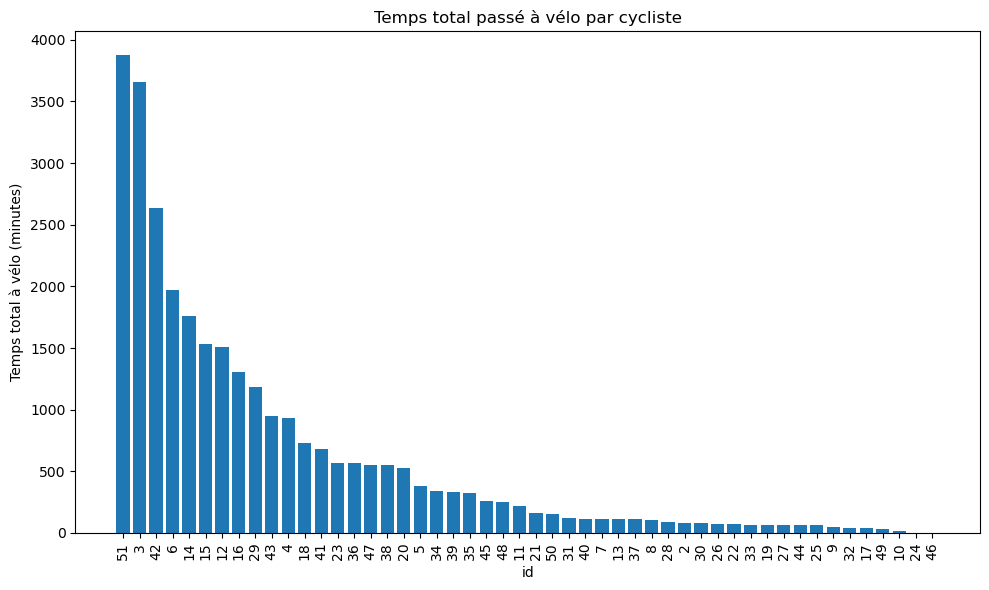

In [15]:
import matplotlib.pyplot as plt

temps_total = (
    trajets_pd
    .groupby("id")["duree_trajet_minutes"]
    .sum()
    .reset_index()
    .sort_values("duree_trajet_minutes", ascending=False)
)

plt.figure(figsize=(10, 6))
plt.bar(temps_total["id"].astype(str), temps_total["duree_trajet_minutes"])
plt.xlabel("id")
plt.ylabel("Temps total à vélo (minutes)")
plt.title("Temps total passé à vélo par cycliste")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

2) Réalisez un graphique en barre qui affiche le temps de chaque trajet d'un cycliste. Faites en sorte qu'on puisse choisir un id et afficher les trajets de cet id.

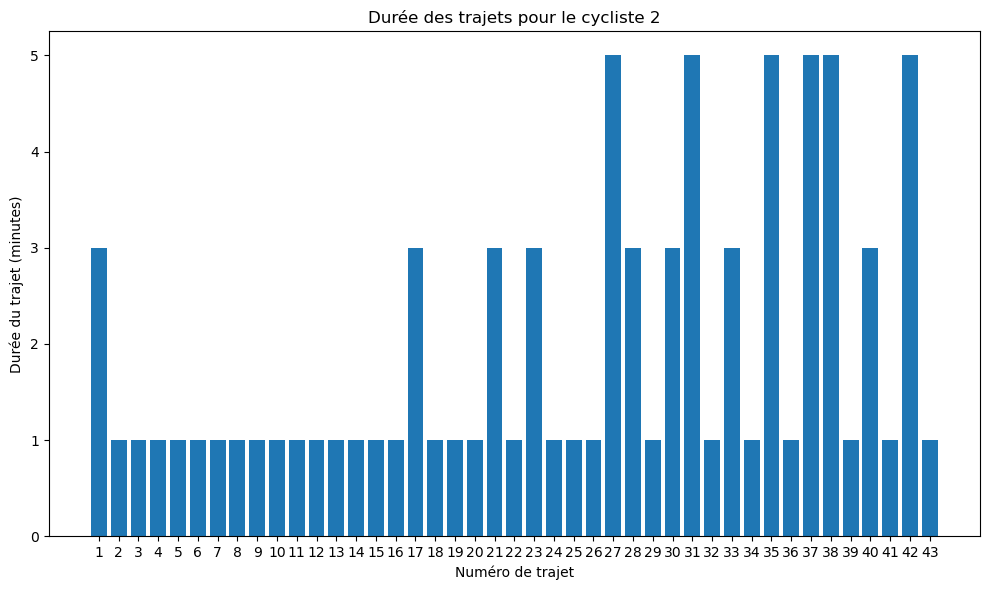

In [16]:
id_selectionne = trajets_pd["id"].unique()[0]

trajets_id = (
    trajets_pd[trajets_pd["id"] == id_selectionne]
    .sort_values("numero_de_trajet")
)

plt.figure(figsize=(10, 6))
plt.bar(trajets_id["numero_de_trajet"].astype(str), trajets_id["duree_trajet_minutes"])
plt.xlabel("Numéro de trajet")
plt.ylabel("Durée du trajet (minutes)")
plt.title(f"Durée des trajets pour le cycliste {id_selectionne}")
plt.tight_layout()
plt.show()

## 6) Sauvegarde

Sauvegardez votre dataset trajets au format csv dans le dossier data.

In [19]:
trajets.coalesce(1).write.csv("data/trajets_cyclistes", header=True, mode="overwrite")